## Tutorial 2: Recurrent Neural Language Modelling


#### Recurrent Neural Network (RNN)
A recurrent neural network (RNN) is a neural network with a recurrent hidden layer $\pmb{h}$ to operate over a sequence input $\pmb{x} = (x_1,...,x_{|\pmb{x}|})$, one symbol at a time. The recurrent connection represents that the hidden state at a time step becomes input of next time step. Having recurrent connection among hidden units, RNN can model long distance dependencies due to ability to pass information between time step. 

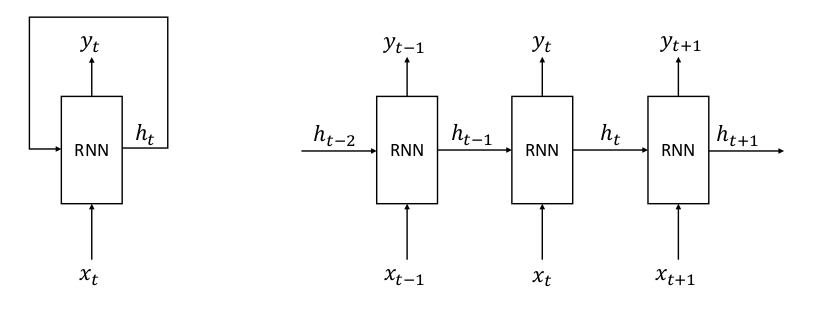

Above image shows a RNN and its unfolding in time. Generally, at time step $t$, the hidden state $h_t$ and output $y_t$  is updated as follows
\begin{align}
h_t &= \textrm{RNN}(h_{t-1}, x_t) \\ 
y_t &= \text{O}(h_t) = h_t 
\end{align}

where $\textrm{RNN}$ and $O$ denotes the function that computes hidden state and output vector. In simplest case, output function can be identity function as shown in previous equation. The simplest RNN formulation is Elman Network  which used $\tanh$ as activation function
\begin{align}
h_t &= 
\begin{cases}
	\tanh(h_{t_1}W^h + x_tW^x + b) & \quad    (t \geq 1) \\ 
	0 & \quad \text{ otherwise}
\end{cases} \\
\end{align}
where $W^h, W^x$ are weight matrices, $b$ is bias term.

#### Long Short Term Memory (LSTM)
Because of repeatedly multiplication of weighted matrix, Elman Network suffers from vanishing and exploding gradient problem when training network by back propagation through time. Long Short-Term Memory (LSTM) unit is proposed to address this problem. It consists of a memory cell $\pmb{c}$ that accumulate the information observed up to current step and three gates - input gate $\pmb{i}$, output gate $\pmb{o}$, and forget gate $\pmb{f}$, which control how much information are retained at each computation step. More precisely,
\begin{align}
z_t &= \tanh(x_tW^{xz} + h_{t-1}W^{hz} + b_z) \\ 
o_t &= \sigma(x_tW^{xo} + h_{t-1}W^{ho} + b_o) \\
f_t &= \sigma(x_tW^{xf} + h_{t-1}W^{hf} + b_f) \\
i_t &= \sigma(x_tW^{xi} + h_{t-1}W^{hi} + b_i) \\
c_t &= f_t \odot c_{t-1} + i_t \odot z_t \\ 
h_t &= o_t \odot \tanh(c_t)
\end{align}
where $W^{xz}, W^{hz}, W^{xo}, W^{xf}, W^{hf}, W^{xi}, W^{hi}$ are weight matrices and $b_z, b_o, b_f, b_i$ are bias terms.  The LSTM equation to compute $z_t$ is the same with the RNN equation to compute hidden states of Elman Network. By introducing gating mechanism and memory cell, LSTM unit reduce the amount of update value and prevent gradient become too small or too large. The memory cell is updated by the sum of a fraction of the previous memory ($f_t \odot c_{t-1}$) and a fraction of the proposed update ($i_t \odot z_t$). Finally, the hidden state is updated based on how much the cell memory to affect the next state ($o_t \odot \tanh(c_t)$).

#### Recurrent Neural Language Model
Similar to n-gram language model, the probability of a whole sentences are calculated by applying chained rules on probability of a word conditioned on previous words. However, unlike n-gram language model, the conditioned context does not limit to (n-1) previous word, but consider all words from the beginning of sentence.
\begin{align}
P(\mathbf{w}) &= \prod_{i=1}^{n} P(w_{i}|\pmb{w}_{\le i-1}) = \prod_{i=1}^{n} \textrm{RNN}(h_{i-1}, w_i) 
\end{align}

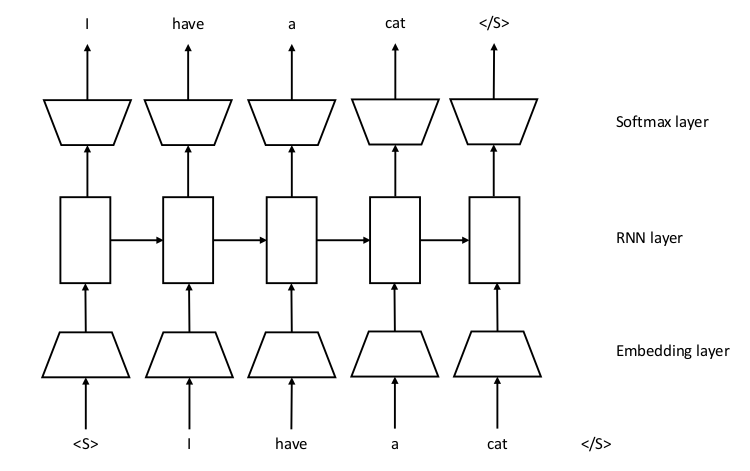
The training objective is also to maximize the log likelihood of the correct words.

#### Data Preparation
In this tutorial, we use the same PTB data from Tutorial 1.
Datasets to do the exercise: [PTB dataset](https://github.com/tomsercu/lstm/tree/master/data) in `./data/ptb` folder
This corpus is already preprocessed. Low frequency words are also replaced with a special token `<unk>`. 
When reading data, we also need to replace `\n` character with end-of-sequence token `<eos>`

In [1]:
def read_files(filename):
    with open(filename) as fin:
        data = fin.read().replace("\n", "<eos>").split()
    return data
train_data = read_files('./data/ptb/ptb.train.small.txt')
dev_data = read_files('./data/ptb/ptb.valid.small.txt')
test_data = read_files('./data/ptb/ptb.test.small.txt')

Construct vocabulary

In [2]:
# construct vocabulary
import collections
counter = collections.Counter(train_data)
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
vocab_size = len(count_pairs)
words, _ = list(zip(*count_pairs))
word_to_id = dict(zip(words, range(len(words))))

Prepare data:
* We chop dataset into sequences of same length

In [3]:
#Prepare train data
n = 10 # max time step / sequence length
unk_id = word_to_id["<unk>"]
train = [word_to_id.get(word, unk_id) for word in train_data]
train_pair = [[train[i:i + n], train[i+1:i+ n + 1]]
            for i in range(len(train) - n)]
dev = [word_to_id.get(word, unk_id) for word in dev_data]
dev_pair = [[dev[i:i + n], dev[i +1: i + n + 1]]
            for i in range(len(dev) - n )]
test = [word_to_id.get(word, unk_id) for word in test_data]
test_pair = [[test[i:i + n], test[i+1:i + n + 1]]
            for i in range(len(test) - n )]

### Implementation in Tensorflow

In [4]:
import tensorflow as tf
import numpy as np

#### Neural Network Declaration

Declare model input

In [5]:
embedding_size = 32
hidden_size = 32
x = tf.placeholder(tf.int32, shape=(None, n), name="x")
y = tf.placeholder(tf.int32, shape=(None, n), name="y")

Declare model parameters

In [6]:
embeddings = tf.get_variable("embeddings",[vocab_size, embedding_size])
W_rnn = tf.Variable(np.random.rand(hidden_size + embedding_size, hidden_size), name="W_rnn", dtype=tf.float32)
b_rnn = tf.Variable(np.zeros(hidden_size), name="b_rnn", dtype=tf.float32)
W_softmax = tf.Variable(np.random.rand(hidden_size, vocab_size), name="W_softmax", dtype=tf.float32)
b_softmax = tf.Variable(np.zeros(vocab_size), name="b_softmax", dtype=tf.float32)

Declare embedding layer

In [7]:
emb = tf.nn.embedding_lookup(embeddings, x)

Declare RNN

In [8]:
shape = tf.shape(emb)
time_steps = shape[1]
batch_size = shape[0]

#transpose inputs shape from batchsize x timestep x embedding to timestep x batchsize x embedding
inputs = tf.transpose(emb, [1,0,2])
state = tf.zeros([batch_size, hidden_size], dtype=tf.float32)
output = tf.zeros([batch_size, vocab_size], dtype=tf.float32)
def while_loop_cond(i, outputs, output, state):
    return tf.less(i, time_steps)
    
def while_body(i, outputs, output, state):
#     input = tf.reshape(inputs[i], [-1, embedding_size])
    tmp = tf.concat([state, inputs[i]], axis=1)
    state = tf.tanh(tf.nn.xw_plus_b(tmp, W_rnn, b_rnn))
    output = tf.nn.xw_plus_b(state, W_softmax, b_softmax)
    outputs = outputs.write(i, output)
    return [tf.add(i, 1), outputs, output, state]
init_outputs = tf.TensorArray(tf.float32, size=time_steps)
i, outputs, output, state = tf.while_loop(while_loop_cond, while_body,
                                                  [tf.constant(0), init_outputs, output, state])
outputs = outputs.stack()
#transpose back to batchsize x timestep x hidden 
outputs = tf.transpose(outputs, [1, 0, 2])

Calculate loss entropy 

In [9]:
# cross entropy
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=outputs, labels=y)
loss_op = tf.reduce_mean(crossent)

Declare optimizer

In [10]:
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss_op)

Prediction output

In [11]:
pred_op = tf.argmax(outputs, 1)

#### Train model

Init TensorFlow session

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Training loop

In [13]:
num_epoch = 10
batch_size = 100
num_step = int(len(train_pair) / batch_size)

history_loss = []
history_dev_loss = []

dev_x = np.asarray(dev_pair)[:,0].tolist()
dev_y = np.asarray(dev_pair)[:,1].tolist()
for epoch in range(num_epoch):
    #Shuffle training data
    np.random.shuffle(train_pair)
    for step in range(num_step):
        minibatch = train_pair[step*batch_size:(step+1)*batch_size]
        batch_x = np.asarray(minibatch)[:,0].tolist()
        batch_y = np.asarray(minibatch)[:,1].tolist()  
        loss, _ = sess.run([loss_op, train_op], feed_dict={x: batch_x, y: batch_y})
        if (step + 1) % 500 == 0:                
            #run on validation set
            dev_loss = sess.run(loss_op, feed_dict={x: dev_x, y: dev_y})                
            history_loss.append(loss)
            history_dev_loss.append(dev_loss)
            print("Epoch " + str(epoch) + " Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Dev loss {:.4f}".format(dev_loss))

Epoch 0 Step 499, Minibatch Loss= 8.2055, Dev loss 8.0591
Epoch 0 Step 999, Minibatch Loss= 7.7182, Dev loss 7.5452
Epoch 1 Step 499, Minibatch Loss= 7.0112, Dev loss 7.1725
Epoch 1 Step 999, Minibatch Loss= 7.1639, Dev loss 7.0341
Epoch 2 Step 499, Minibatch Loss= 6.8691, Dev loss 6.7909
Epoch 2 Step 999, Minibatch Loss= 6.8878, Dev loss 6.7368
Epoch 3 Step 499, Minibatch Loss= 6.9262, Dev loss 6.6932
Epoch 3 Step 999, Minibatch Loss= 6.8367, Dev loss 6.6614
Epoch 4 Step 499, Minibatch Loss= 6.7172, Dev loss 6.6333
Epoch 4 Step 999, Minibatch Loss= 6.7071, Dev loss 6.6169
Epoch 5 Step 499, Minibatch Loss= 6.6733, Dev loss 6.5966
Epoch 5 Step 999, Minibatch Loss= 6.6197, Dev loss 6.5844
Epoch 6 Step 499, Minibatch Loss= 6.6216, Dev loss 6.5687
Epoch 6 Step 999, Minibatch Loss= 6.5099, Dev loss 6.5622
Epoch 7 Step 499, Minibatch Loss= 6.6448, Dev loss 6.5519
Epoch 7 Step 999, Minibatch Loss= 6.7572, Dev loss 6.5442
Epoch 8 Step 499, Minibatch Loss= 6.5177, Dev loss 6.5405
Epoch 8 Step 9

Plot of loss on train (red line) and dev (blue line) set

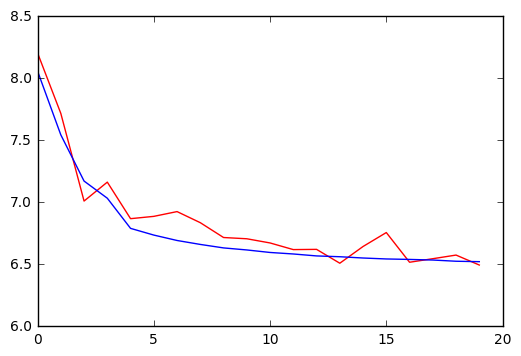

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history_loss, 'r')
plt.plot(history_dev_loss, 'b')

#### Inference

In [15]:
np.random.shuffle(test_pair)
test_x = np.asarray(test_pair)[:,0].tolist()
test_y = np.asarray(test_pair)[:,1].tolist()

#inference step
pred = sess.run(pred_op, feed_dict={x: test_x}) 
flat_pred = [item for sublist in pred for item in sublist]
flat_y = [item for sublist in test_y for item in sublist]
accuracy = sum(1 for a,b in zip(flat_pred,flat_y) if a == b)/len(flat_pred)
print("Test accuracy {:.4f}".format(accuracy))

Test accuracy 0.0001
